## Sanity Check
* Find evidence that SAVE is not working
  * Q: The difference in weight b/w relevant features and irrelevant features are diminishing when the number of total features increases?
    * Setup experiments by using 10 relevant features
    * Generate predictors via Donglai's method
    * Save the accuracy df and direction matrix, record baseline accuracy
    * Calculate the variance in each direction matrix
    * Plot learning curve: 1. accuracy 2. variance in direction matrix w.r.t. each synthetic dataset
* Good to see the diminishing pattern of the variance
* Control noise level -> 5% / 10% / 20% of the average range in every interval of percentile for thresholding

In [12]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
from glob import glob
# !pip install sliced
import sliced
import random
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sliced import SlicedAverageVarianceEstimation
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
# from numba import njit
from numpy.linalg import pinv
from tqdm import tqdm
%xmode plain

Exception reporting mode: Plain


In [57]:
def mahalanobis_transformation(feature_df, flag = "Train", feature_mean = np.empty((1,1)), sigma_pinv_sqrt = np.empty((1,1))):
    # whiten the data
    n = feature_df.shape[0]
    p = feature_df.shape[1]
    ones = np.ones((n, 1)) # n * 1
    if flag == "Train":
        # aviod np.mean in numba cannot use globals()
        feature_mean = np.empty((1,p))
        for i in range(p):
            feature_mean[0,i] = np.mean(feature_df[:,i], axis = 0)
        feature_centered = feature_df - np.dot(ones, feature_mean)
        # get cov matrix # p * p
        cov = np.dot(feature_centered.T, feature_centered) / n
        # u, s, vh = np.linalg.svd(cov) # all real numbers
        s, u = np.linalg.eigh(cov) # all real numbers
        # theshold for pinv: 1e-15
        s_pinv = np.linalg.pinv(np.diag(s))
        s_pinv_sqrt = np.zeros(p)
        for i, item in enumerate(np.diag(s_pinv)):
            if item > 0:
                s_pinv_sqrt[i] = np.sqrt(item)
        sigma_pinv_sqrt = np.dot(np.dot(u, np.diag(s_pinv_sqrt)), u.T)
        feature_df_whitened = np.dot(feature_centered, sigma_pinv_sqrt)
    else:
        if feature_mean is None or sigma_pinv_sqrt is None:
            raise ValueError("Need to assign feature mean vector and Sigma!")
        if feature_mean is not None and sigma_pinv_sqrt is not None:
            feature_centered = feature_df - np.dot(ones, feature_mean)
            feature_df_whitened = np.dot(feature_centered, sigma_pinv_sqrt)
    return feature_df_whitened, feature_mean, sigma_pinv_sqrt

def get_cov_mat(feature_df):
    n = feature_df.shape[0]
    p = feature_df.shape[1]
    ones = np.ones((n, 1))
    feature_mean = np.empty((1,p))
    for i in range(p):
        feature_mean[0,i] = np.mean(feature_df[:,i])
    feature_centered = feature_df - np.dot(ones, feature_mean)
    # get cov matrix # p * p
    cov = np.dot(feature_centered.T, feature_centered) / n
    return cov

def my_SAVE(feature_df_whitened, label_df, flag = "Train", n_directions = 977, verbose = False, **kwargs):

    if flag == "Train":
        # get slices
        label_df.index = np.arange(0, label_df.shape[0], dtype = int)
        slice_index_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
        n = feature_df_whitened.shape[0]
        p = feature_df_whitened.shape[1]
        for i in np.arange(5):
            slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
            globals()['feature_df_' + str(i + 1)] = feature_df_whitened[slice_index_dict[i + 1],:]
            globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
            # get sliced cov matrices
            globals()['cov_' + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
        # concatenate 5 cov matrices, weighted by the proportion of classes
        globals()['weight_df'] = label_df["label"].value_counts() / label_df.shape[0]
        weighted_cov = pd.DataFrame(
            data = np.zeros((globals()['cov_1'].shape[0], globals()['cov_1'].shape[0])), 
            columns = np.arange(p, dtype = int)
        )
        for i in np.arange(5):
            if p == 2:
                if verbose:
                    # u, s, vh = np.linalg.svd(globals()['cov_' + str(i + 1)])
                    u, s = np.linalg.eigh(globals()['cov_' + str(i + 1)])
                    s = s[::-1]
                    u = u[:, ::-1]
                    print(f'Eigen values of COV mat: {s}')
                    print(f'Eigen values ratio of COV mat: {s[0] / s[1]:8.4f}')
                    print(f'(1 - Eigen values of COV mat) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                    print(f'(1 - Eigen values of COV mat)^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')
                    # u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                    s, u = np.linalg.eigh(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                    s = s[::-1]
                    u = u[:, ::-1]
                    print(f'Eigen values of (I - COV mat): {s}')
                    print(f'Eigen values ratio of (I - COV mat) : {s[0] / s[1]:8.4f}')
                    print(f'(1 - Eigen values of (I - COV mat)) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                    print(f'(1 - Eigen values of (I - COV mat))^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')

            if verbose:
                # u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                s, u = np.linalg.eigh(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                s = s[::-1]
                u = u[:, ::-1]
                print(f'(I - V) eigenvalues: {s}')
                # u, s, vh = np.linalg.svd((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
                s, u = np.linalg.eigh((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
                s = s[::-1]
                u = u[:, ::-1]
                print(f'(I - V)^2 eigenvalues: {s}')
            temp = np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]
            weighted_cov += weight_df.loc[i + 1] * temp @ temp.T
        # u, s, vh = np.linalg.svd(weighted_cov)
        s, u = np.linalg.eigh(weighted_cov)
        s = s[::-1]
        u = u[:, ::-1]
        b = u[:,:n_directions]
        # transformed to vectors in th original scale
        h = sigma_pinv_sqrt @ b
        globals()['directions'] = normalize(h, axis = 0)
        feature_df_reduced = feature_df_whitened @ globals()['directions']
        print()
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
        feature_df_reduced = feature_df_whitened @ globals()['directions']
    return feature_df_reduced, feature_df_whitened, feature_mean, sigma_pinv_sqrt

def sliced_SAVE(feature_df_whitened, label_df, flag = "Train", n_directions = 977, **kwargs):
    if flag == "Train":
        globals()['save'] = SlicedAverageVarianceEstimation(n_directions = n_directions, n_slices = 5)
        globals()['save'].fit(feature_df_whitened, label_df)
        globals()['directions'] = globals()['save'].directions_
        feature_df_reduced = globals()['save'].transform(feature_df_whitened)
    else:
        feature_df_reduced = globals()['save'].transform(feature_df_whitened)
    return feature_df_reduced, feature_df_whitened, feature_mean, sigma_pinv_sqrt

def my_lr(feature_df_train, feature_df_test, label_df_train, label_df_test):
    lr_params_grid = {
        'C': [0, 0.1, 0.5, 1, 10, 100], 
        'tol': [1e-4], 
        'penalty': ['l2'],  
        'random_state': [42], 
        'max_iter': [2000], 
        'verbose': [0], 
        'solver': ['newton-cg'], 
        'n_jobs': [6]
    }

    gs_lr = GridSearchCV(
        estimator = LogisticRegression(), 
        param_grid = lr_params_grid, 
        cv = 5, 
        scoring = 'accuracy', 
        verbose = 0, 
        n_jobs = -1
    )
    gs_lr.fit(feature_df_train, np.array(label_df_train).ravel())
    best_lr = gs_lr.best_estimator_
    lr_pred = best_lr.predict(feature_df_test)
    lr_f1 = f1_score(y_true = label_df_test, y_pred = lr_pred, average = 'macro')
    lr_accu = accuracy_score(y_true = label_df_test, y_pred = lr_pred)
    print('Best params: ')
    print(gs_lr.best_params_)
    print(f'Accuracy: {lr_accu:8.4f}\n')
    print('-------------------------------------------------------------------')
    return lr_f1, lr_accu

def my_XGB(feature_df_train, feature_df_test, label_df_train, label_df_test):
    xgb_params_grid = {
        'tree_method': ['gpu_hist'], 
        'n_estimators': [50, 100, 200], 
        'max_depth': [3, 4, 5, 6], 
        'n_jobs': [-1], 
        'random_state': [42], 
        'gpu_id': [0], 
        'predictor': ["gpu_predictor"]
    }
    gs = GridSearchCV(
        estimator = XGBClassifier(), 
        param_grid = xgb_params_grid, 
        cv = 5, 
        scoring = 'accuracy', 
        verbose = 0, 
        n_jobs = -1
    )
    gs.fit(feature_df_train, np.array(label_df_train).ravel())
    best_clf = gs.best_estimator_
    pred = best_clf.predict(feature_df_test)
    f1 = f1_score(y_true = label_df_test, y_pred = pred, average = 'macro')
    accu = accuracy_score(y_true = label_df_test, y_pred = pred)
    print('\nBest params: ')
    print(gs.best_params_)
    print(f'Accuracy: {accu:8.4f}\n')
    print('----------------------------------------------------------------------------------------------------')
    return f1, accu


def generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 500, test_size = 0.2, noise_level = 0.1, **kwargs):
    import pandas as pd
    import numpy as np
    import random
    from sklearn.model_selection import train_test_split
    total_features = core_dirs + redundant_dirs
    max_power = 4

    def method1(total_features, core_dirs, max_power, noise_level):
        x = np.random.randn(size, total_features)
        fx = 0
        for i in range(core_dirs + 1):
            fx = x[:,i] ** max(max_power + 1 - i, 1)
        average_interval_range = (np.max(fx) - np.min(fx)) / 5.0
        y_noise = fx + np.random.normal(loc = 0, scale = noise_level * average_interval_range, size = size) # noise std = noise_level * average_interval_range
        # thresholding by quantile w/o noise
        y_discrete = pd.cut(
            y_noise, 
            bins = [np.min(y_noise) - 1, np.quantile(fx,0.2), np.quantile(fx,0.4), np.quantile(fx,0.6), np.quantile(fx,0.8), np.max(y_noise) + 1], 
            labels = np.arange(5) + 1
        )
        assert np.sum(y_discrete.isna()) == 0
        return x, y_discrete, noise_level

    x, y_discrete, _ = method1(total_features, core_dirs, max_power, noise_level)
    feature_train, feature_test, label_train, label_test = train_test_split(
        x, y_discrete, 
        test_size = test_size, 
        shuffle = True, 
        random_state = 42
    )
    return feature_train, feature_test, label_train, label_test

# def train_learning_curve(synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test, method = my_SAVE, clf = my_lr):
#     n_directions_list = list(np.arange(1, synthetic_feature_df_train.shape[1] + 1, dtype = int))
#     f1_list = []
#     accu_list = []
#     global feature_mean
#     global sigma_pinv_sqrt
#     for n_direction in tqdm(n_directions_list):
#         # synthetic_label_df_train = np.asarray(synthetic_label_df_train)
#         # synthetic_label_df_test = np.asarray(synthetic_label_df_test)
#         globals()['feature_df_reduced_' + str(n_direction) + "_train"], synthetic_feature_df_train_whitened, feature_mean, sigma_pinv_sqrt = method(
#             synthetic_feature_df_train, 
#             synthetic_label_df_train, 
#             flag = "Train", 
#             n_directions = n_direction
#         )
#         globals()['feature_df_reduced_' + str(n_direction) + "_test"], synthetic_feature_df_test_whitened, _, _ = method(
#             synthetic_feature_df_test, 
#             synthetic_label_df_test, 
#             flag = "Test", 
#             n_directions = n_direction, 
#             feature_mean = feature_mean, 
#             sigma_pinv_sqrt = sigma_pinv_sqrt
#         )
#         curr_test_f1, curr_test_accu = clf(
#             feature_df_train = globals()['feature_df_reduced_' + str(n_direction) + "_train"], 
#             feature_df_test = globals()['feature_df_reduced_' + str(n_direction) + "_test"], 
#             label_df_train = synthetic_label_df_train, 
#             label_df_test = synthetic_label_df_test
#         )
#         f1_list.append(curr_test_f1)
#         accu_list.append(curr_test_accu)

#     # train w/ original features -> syncthetic_feature_df -> whitened
#     baseline_test_f1, baseline_test_accu = my_lr(
#         feature_df_train = synthetic_feature_df_train_whitened, 
#         feature_df_test = synthetic_feature_df_test_whitened, 
#         label_df_train = synthetic_label_df_train, 
#         label_df_test = synthetic_label_df_test
#     )
#     return f1_list, accu_list, baseline_test_f1, baseline_test_accu, n_directions_list

def train_one_dataset(synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test, method = sliced_SAVE, clf = my_lr):
    global feature_mean
    global sigma_pinv_sqrt
    assert method == sliced_SAVE

    feautre_reduced_train, _, feature_mean, sigma_pinv_sqrt = method(
        synthetic_feature_df_train, 
        synthetic_label_df_train, 
        flag = "Train", 
        n_directions = 'auto'
    )
    feature_redued_test, _, _, _ = method(
        synthetic_feature_df_test, 
        synthetic_label_df_test, 
        flag = "Test", 
        n_directions = 'auto', 
        feature_mean = feature_mean, 
        sigma_pinv_sqrt = sigma_pinv_sqrt
    )
    curr_test_f1, curr_test_accu = clf(
        feature_df_train = feautre_reduced_train, 
        feature_df_test = feature_redued_test, 
        label_df_train = synthetic_label_df_train, 
        label_df_test = synthetic_label_df_test
    )
    # train w/ original features -> syncthetic_feature_df -> whitened
    baseline_test_f1, baseline_test_accu = my_lr(
        feature_df_train = synthetic_feature_df_train, 
        feature_df_test = synthetic_feature_df_test, 
        label_df_train = synthetic_label_df_train, 
        label_df_test = synthetic_label_df_test
    )
    return curr_test_f1, curr_test_accu, baseline_test_f1, baseline_test_accu, globals()['directions']



def train_loop(core_dirs, redundant_dirs, size = 500, test_size = 0.2, noise_level = 0.1, n_iteration = 4, save = False, suffix = "", method = sliced_SAVE):
    if save:
        if suffix == "":
            raise ValueError("No filename suffix assigned!")
    total_features = core_dirs + redundant_dirs
    var_directions_list = []
    directions_kept_list = []
    for i in tqdm(np.arange(n_iteration)):
        f1_list, accu_list = [], []
        synthetic_feature_df_train, synthetic_feature_df_test, synthetic_label_df_train, synthetic_label_df_test = generate_synthetic_data(
            core_dirs = core_dirs, 
            redundant_dirs = redundant_dirs, 
            size = size, 
            test_size = test_size, 
            noise_level = noise_level
        )
        if synthetic_feature_df_train.shape[0] < synthetic_feature_df_train.shape[1]:
            pca = PCA()
            synthetic_feature_df_train = pca.fit_transform(synthetic_feature_df_train)
            synthetic_feature_df_test = pca.transform(synthetic_feature_df_test)
        global feature_mean, sigma_pinv_sqrt
        
        feature_train_whitened_std, feature_mean, sigma_pinv_sqrt = mahalanobis_transformation(synthetic_feature_df_train, flag = "Train") # whitening
        feature_test_whitened_std, _, _ = mahalanobis_transformation(synthetic_feature_df_test, flag = "Test", feature_mean = feature_mean, sigma_pinv_sqrt = sigma_pinv_sqrt) # whitening
        std = StandardScaler()
        feature_train_std = std.fit_transform(feature_train_whitened_std) # standardizzation
        feature_test_std = std.transform(feature_test_whitened_std) # standardizzation
        f1, accu, baseline_f1, baseline_accu, directions = train_one_dataset(
            feature_train_std, 
            synthetic_label_df_train, 
            feature_test_std, 
            synthetic_label_df_test, 
            method = method, 
            clf = my_lr
        )
        # calculate columnwise variance 
        var_directions = np.mean(np.var(directions, axis = 1))
        directions_kept = directions.shape[1]
        var_directions_list.append(var_directions)
        directions_kept_list.append(directions_kept)

    return core_dirs, redundant_dirs, np.mean(var_directions_list), np.mean(directions_kept_list)


In [81]:
feature_train, feature_test, label_train, label_test = generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 500, test_size = 0.2, noise_level = 0.1)

In [82]:
label_train.value_counts()

1    87
2    59
3    82
4    92
5    80
dtype: int64

## Simulation

In [75]:
from sklearn.exceptions import FitFailedWarning
import warnings
warnings.simplefilter("ignore")
def simulation(core_feature_proportion, noise_level):
    simu_result_df = pd.DataFrame(
        data = None, 
        columns = ['relevant_features', 'irrelevant_features', 'mean_var', 'mean_directions_kept']
    )
    for i in tqdm(np.logspace(base = 10.0, start = 1, stop = 3, num = 20)):
        total_features = int(i)
        core_dirs = int(core_feature_proportion * total_features)
        redundant_dirs = total_features - core_dirs
        _, _, mean_var_directions, mean_directions_kept = train_loop(core_dirs, redundant_dirs, noise_level = noise_level)
        simu_result_df = simu_result_df.append(pd.DataFrame([[core_dirs, redundant_dirs, mean_var_directions, mean_directions_kept]], columns = simu_result_df.columns))
    return simu_result_df

simu_result_df = simulation(core_feature_proportion = 0.1, noise_level = 0.1)

  0%|          | 0/20 [00:00<?, ?it/s]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4300

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2500

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3800

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3500

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3700

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4500

-------------------------------------------------------------------


  5%|▌         | 1/20 [00:04<01:31,  4.80s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4500

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3600

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2800

-------------------------------------------------------------------
Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3400

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2300

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3600

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3500

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4100

-------------------------------------------------------------------


 10%|█         | 2/20 [00:09<01:28,  4.90s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3800

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3900

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3400

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3500

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3000

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3500

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3300

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3300

-------------------------------------------------------------------


 15%|█▌        | 3/20 [00:14<01:24,  4.96s/it]

Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4300

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3100

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4600

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3000

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4600

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6400

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6100

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3100

-------------------------------------------------------------------


 20%|██        | 4/20 [00:19<01:19,  4.94s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4800

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4800

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5900

-------------------------------------------------------------------
Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3800

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5200

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4800

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4500

-------------------------------------------------------------------


 25%|██▌       | 5/20 [00:24<01:15,  5.05s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5500

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2300

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2300

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2100

-------------------------------------------------------------------
Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2100

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1700

-------------------------------------------------------------------


 30%|███       | 6/20 [00:30<01:12,  5.18s/it]

Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2400

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6800

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.7000

-------------------------------------------------------------------
Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.7100

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.7500

-------------------------------------------------------------------
Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6700

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.7900

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4400

-------------------------------------------------------------------


 35%|███▌      | 7/20 [00:36<01:10,  5.42s/it]

Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.7700

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2400

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6200

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2500

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5700

-------------------------------------------------------------------
Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2100

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.7100

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2100

-------------------------------------------------------------------


 40%|████      | 8/20 [00:42<01:07,  5.59s/it]

Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6800

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1600

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6300

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1600

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.6500

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1700

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5800

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


 45%|████▌     | 9/20 [00:48<01:02,  5.66s/it]

Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5400

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2100

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5000

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3200

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5900

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1800

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5100

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1400

-------------------------------------------------------------------


 50%|█████     | 10/20 [00:54<00:58,  5.85s/it]

Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.5300

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3800

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1300

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4900

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4500

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1200

-------------------------------------------------------------------


 55%|█████▌    | 11/20 [01:01<00:56,  6.25s/it]

Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4700

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1400

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3200

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1700

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4400

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1700

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4100

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1200

-------------------------------------------------------------------


 60%|██████    | 12/20 [01:08<00:52,  6.54s/it]

Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4000

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2200

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3900

-------------------------------------------------------------------
Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2800

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4100

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1300

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3700

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


 65%|██████▌   | 13/20 [01:15<00:46,  6.64s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3600

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1300

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3600

-------------------------------------------------------------------
Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2200

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3700

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3300

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3600

-------------------------------------------------------------------
Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1800

-------------------------------------------------------------------


 70%|███████   | 14/20 [01:24<00:43,  7.23s/it]

Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4200

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2200

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2400

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1600

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2500

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1800

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2700

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2400

-------------------------------------------------------------------


 75%|███████▌  | 15/20 [01:32<00:38,  7.69s/it]

Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3700

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2200

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2600

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2700

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1600

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2100

-------------------------------------------------------------------


 80%|████████  | 16/20 [01:43<00:33,  8.46s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1800

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3600

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2800

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2900

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1700

-------------------------------------------------------------------


 85%|████████▌ | 17/20 [01:54<00:27,  9.23s/it]

Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3300

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2200

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2400

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1800

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.4100

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1400

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2800

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


 90%|█████████ | 18/20 [02:06<00:20, 10.12s/it]

Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2500

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2700

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1700

-------------------------------------------------------------------


Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3200

-------------------------------------------------------------------
Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2000

-------------------------------------------------------------------


Best params: 
{'C': 1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2600

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2200

-------------------------------------------------------------------


 95%|█████████▌| 19/20 [02:18<00:10, 10.80s/it]

Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1900

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2700

-------------------------------------------------------------------
Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2300

-------------------------------------------------------------------


Best params: 
{'C': 0.5, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.3000

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2400

-------------------------------------------------------------------


Best params: 
{'C': 0.1, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2500

-------------------------------------------------------------------
Best params: 
{'C': 100, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.1600

-------------------------------------------------------------------


100%|██████████| 20/20 [02:32<00:00,  7.60s/it]

Best params: 
{'C': 10, 'max_iter': 2000, 'n_jobs': 6, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}
Accuracy:   0.2500

-------------------------------------------------------------------


In [76]:
simu_result_df.to_csv(
    '../output/var_simu_df_0.1_0.1.csv', 
    header = True
)

In [80]:
simu_result_df.index = simu_result_df['relevant_features']
simu_result_df

,relevant_features,irrelevant_features,mean_var,mean_directions_kept,total_features
relevant_features,,,,,
1,1,9,0.086443,10.0,10
1,1,11,0.076705,12.0,12
1,1,15,0.059238,16.0,16
2,2,18,0.046888,20.0,20
2,2,24,0.036242,26.0,26
3,3,30,0.029187,33.0,33
4,4,38,0.023032,42.0,42
5,5,49,0.018093,54.0,54
6,6,63,0.014127,69.0,69


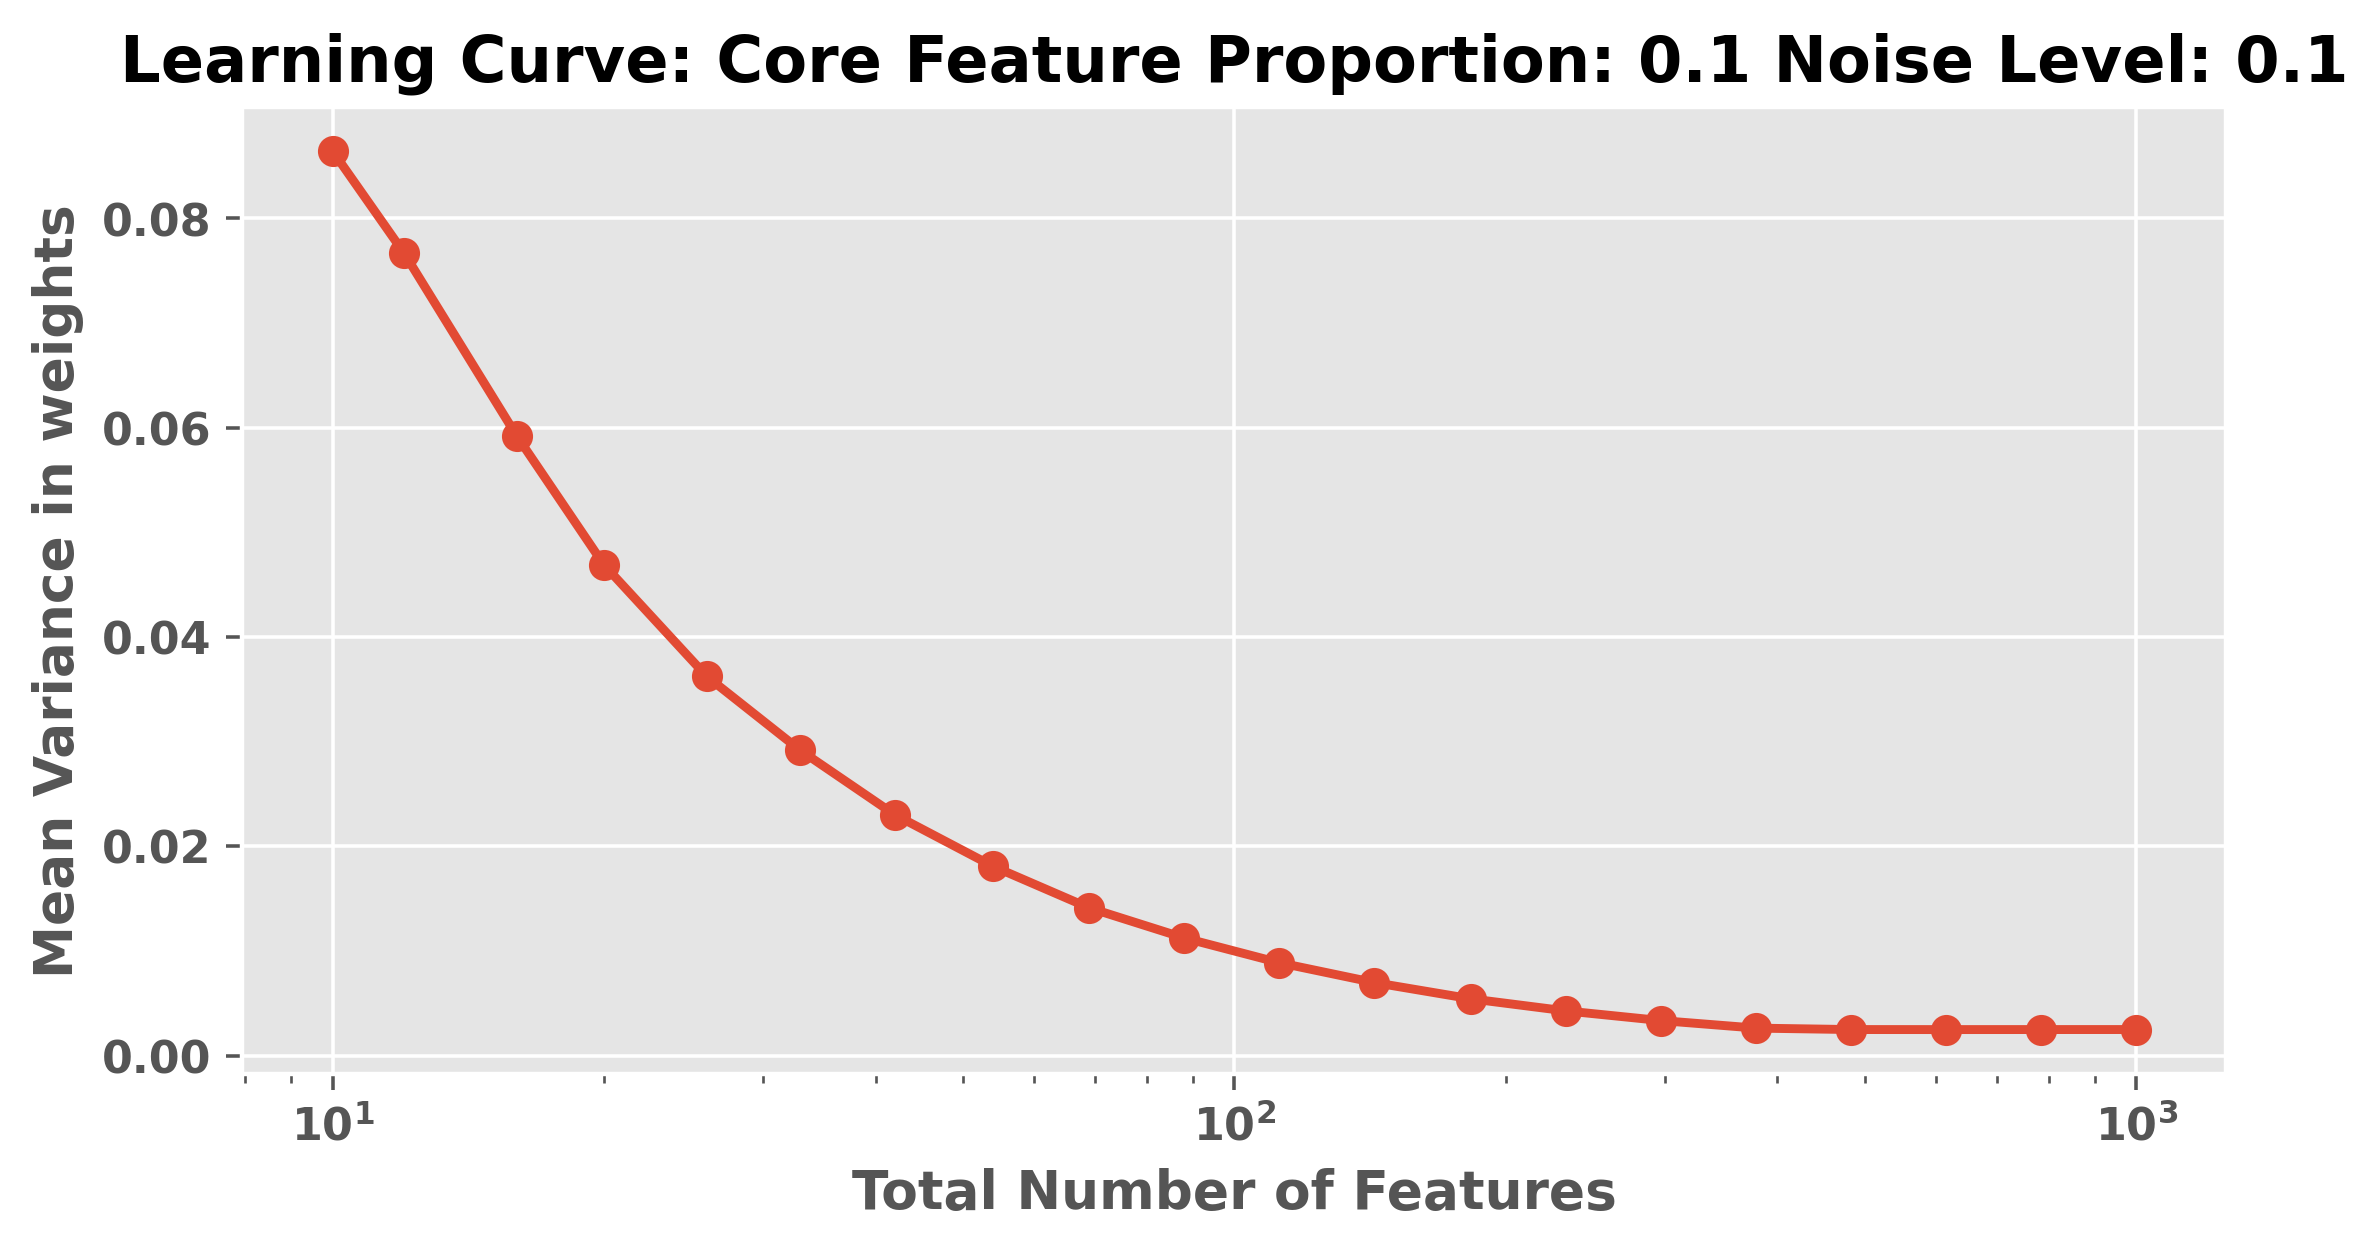

In [79]:
def plot_learning_curve(n_directions_list, validation_score_list, metric_name, x_name, title, x_scale = "linear", save = False, filepath = "", filename = ""):
    '''
    Input: x-axis (e.g. PCA directions kept / n_estimators / max_depth)
           metric_name for y-axis (e.g. misclassification error / crossentropy error / accuracy / f1 score)
           title for this axis
           training + validation score in list
           default in linear scale
           default no saving files, if save is True, then have to specify filename and file path
    Output: inline display of the learning curve
    '''
    import pandas as pd
    import numpy as np  
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib import cm
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    fig,ax = plt.subplots(1, 1, figsize = (8, 4), dpi = 320)
    ax.plot(n_directions_list, validation_score_list, 'o-', linewidth = 2)
    ax.set_xscale(x_scale)
    ax.set_title('Learning Curve: ' + title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(metric_name)
    plt.show()
    if save:
        fig.savefig(filepath + filename + ".png", format = "png")
    pass

simu_result_df['total_features'] = simu_result_df['relevant_features'] + simu_result_df['irrelevant_features']

plot_learning_curve(
    n_directions_list = simu_result_df['total_features'],
    validation_score_list = simu_result_df['mean_var'], 
    metric_name = 'Mean Variance in weights', 
    x_name = 'Total Number of Features', 
    title = 'Core Feature Proportion: 0.1 Noise Level: 0.1', 
    x_scale = 'log', 
    save = True, 
    filepath = '../fig/', 
    filename = 'learning_curve_var_dir_p_0.1_n_0.1'
)